# ANÁLISIS DE VENTAS TUYA Q1 2025

### LIBRERÍAS

In [19]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import plotly.express as px
import plotly.graph_objects  as go
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import statsmodels.api as sm
import statsmodels.formula.api as smf

### FUENTES DE DATOS

In [20]:

# Cargar datos

URL = r"C:\Users\joey_\Documents\Visual Code (Clone)\Proyectos\Tuya\Prueba Técnica Analista de Relacionamiento con el Cliente.xlsx"
df = pd.read_excel(URL)


df.head(3)

,agrup_dato,fecha_corte,Codigo Ejecutivo,Antigüedad,cargo,canal,catt,region,cum tarjetas,cum seguros,cum creditos,Tarjetas,Seguros,Creditos
0,EJECUTIVO,2025-01-31,1111755,Mas de 5 años,Servicio,888586,ÉXITO SOLEDAD,COSTAS,2.00,1.463471,2.250422,6,59,15.190348
1,EJECUTIVO,2025-01-31,1638016,Entre 1 y 5 años,Servicio,305020,ÉXITO SAN PEDRO NEIVA,BOGOTA CENTRO,1.75,0.765079,2.296042,7,36,19.803361
2,EJECUTIVO,2025-01-31,1259264,Mas de 5 años,Servicio,305019,ÉXITO IBAGUE,BOGOTA Y CERCANIAS,1.75,1.053149,2.053781,7,43,11.552520


In [21]:
df.dtypes

agrup_dato                  object
fecha_corte         datetime64[ns]
Codigo Ejecutivo             int64
Antigüedad                  object
cargo                       object
canal                        int64
catt                        object
region                      object
cum tarjetas               float64
cum seguros                float64
cum creditos               float64
Tarjetas                     int64
Seguros                      int64
Creditos                   float64
dtype: object

In [22]:
### QUALITY REPORT (PRE CLEANING)

def create_data_quality_report(df):
    # Initialize dictionary to store quality metrics
    quality_report = {
        'Column_Name': [],
        'Data_Type': [],
        'Total_Rows': [],
        'Missing_Values': [],
        'Missing_Percentage': [],
        'Blank_Values': [],
        'Blank_Percentage': [],
        'Zero_Values': [],
        'Zero_Percentage': [],
        'Unique_Values': []
    }
    
    total_rows = len(df)
    
    for column in df.columns:
        # Count missing values
        missing_count = df[column].isna().sum()
        
        # Count blank values (empty strings)
        blank_count = df[column].astype(str).str.strip().eq('').sum()
        
        # Count zero values for numeric columns
        if pd.api.types.is_numeric_dtype(df[column]):
            zero_count = (df[column] == 0).sum()
        else:
            zero_count = 0
            
        # Count unique values
        unique_count = df[column].nunique()
        
        # Add to report
        quality_report['Column_Name'].append(column)
        quality_report['Data_Type'].append(str(df[column].dtype))
        quality_report['Total_Rows'].append(total_rows)
        quality_report['Missing_Values'].append(missing_count)
        quality_report['Missing_Percentage'].append(round(missing_count/total_rows * 100, 2))
        quality_report['Blank_Values'].append(blank_count)
        quality_report['Blank_Percentage'].append(round(blank_count/total_rows * 100, 2))
        quality_report['Zero_Values'].append(zero_count)
        quality_report['Zero_Percentage'].append(round(zero_count/total_rows * 100, 2))
        quality_report['Unique_Values'].append(unique_count)
    
    # Create DataFrame from the quality report
    quality_df = pd.DataFrame(quality_report)
    
    # Sort by missing percentage (descending)
    quality_df = quality_df.sort_values('Missing_Percentage', ascending=False)
    
    return quality_df

# Create the quality report
quality_report = create_data_quality_report(df)

selected_columns = df.columns[0:13].tolist() 
Q_Report = quality_report[quality_report['Column_Name'].isin(selected_columns)]
Q_Report

,Column_Name,Data_Type,Total_Rows,Missing_Values,Missing_Percentage,Blank_Values,Blank_Percentage,Zero_Values,Zero_Percentage,Unique_Values
0,agrup_dato,object,1181,0,0.0,0,0.0,0,0.00,1
1,fecha_corte,datetime64[ns],1181,0,0.0,0,0.0,0,0.00,3
2,Codigo Ejecutivo,int64,1181,0,0.0,0,0.0,8,0.68,488
3,Antigüedad,object,1181,0,0.0,0,0.0,0,0.00,5
4,cargo,object,1181,0,0.0,0,0.0,0,0.00,2
5,canal,int64,1181,0,0.0,0,0.0,0,0.00,101
6,catt,object,1181,0,0.0,0,0.0,0,0.00,101
7,region,object,1181,0,0.0,0,0.0,0,0.00,5
8,cum tarjetas,float64,1181,0,0.0,0,0.0,199,16.85,510
9,cum seguros,float64,1181,0,0.0,0,0.0,272,23.03,842


### DATA CLEANING

In [23]:
print("\n", df['Antigüedad'].unique())

df['Antigüedad'] = df['Antigüedad'].replace('Mas de 50 años', 'Mas de 5 años')

# Crear diccionario para la codificación de antigüedad
antiguedad_map = {
    'Menos de 6 meses': "0: Menos de 6 meses",
    'entre 6 meses y 1 año': "1: Entre 6 meses y 1 año",
    'Entre 1 y 5 años': "2: Entre 1 y 5 años",
    'Mas de 5 años': "3: Mayor a 5 años"
}

# Aplicar la codificación
df['antiguedad_cod'] = df['Antigüedad'].map(antiguedad_map)


# Mostrar los resultados
print("\n", 'Codificación de antigüedad:')
for k, v in antiguedad_map.items():
    print(f'{v}: {k}')

# Mostrar algunos ejemplos del DataFrame
print("\n", df[['Antigüedad', 'antiguedad_cod']].head(10))

# Convertir columnas de cumplimiento a porcentaje multiplicando por 100
df['cum tarjetas'] = df['cum tarjetas']*100
df['cum seguros'] = df['cum seguros']*100
df['cum creditos'] = df['cum creditos']*100


# Convertir columnas de cumplimiento a formato porcentaje
#df['cum_tarjetas_porc'] = df['cum tarjetas'].map('{:.2%}'.format)
#df['cum_seguros_porc'] = df['cum seguros'].map('{:.2%}'.format)
#df['cum_creditos_porc'] = df['cum creditos'].map('{:.2%}'.format)

# Mostrar los primeros registros para verificar el cambio
print("\n",df[['cum tarjetas', 'cum seguros', 'cum creditos', 'antiguedad_cod']].head(10))



 ['Mas de 5 años' 'Entre 1 y 5 años' 'Menos de 6 meses'
 'entre 6 meses y 1 año' 'Mas de 50 años']

 Codificación de antigüedad:
0: Menos de 6 meses: Menos de 6 meses
1: Entre 6 meses y 1 año: entre 6 meses y 1 año
2: Entre 1 y 5 años: Entre 1 y 5 años
3: Mayor a 5 años: Mas de 5 años

          Antigüedad       antiguedad_cod
0     Mas de 5 años    3: Mayor a 5 años
1  Entre 1 y 5 años  2: Entre 1 y 5 años
2     Mas de 5 años    3: Mayor a 5 años
3     Mas de 5 años    3: Mayor a 5 años
4  Menos de 6 meses  0: Menos de 6 meses
5     Mas de 5 años    3: Mayor a 5 años
6  Menos de 6 meses  0: Menos de 6 meses
7  Entre 1 y 5 años  2: Entre 1 y 5 años
8     Mas de 5 años    3: Mayor a 5 años
9  Menos de 6 meses  0: Menos de 6 meses

    cum tarjetas  cum seguros  cum creditos       antiguedad_cod
0    200.000000   146.347145    225.042197    3: Mayor a 5 años
1    175.000000    76.507933    229.604189  2: Entre 1 y 5 años
2    175.000000   105.314918    205.378126    3: Mayor a 5 años
3 

### Validación de posibles cumplimientos faltantes

In [24]:
df_faltantes = df.copy()

tarjetas_faltantes = df_faltantes[(df_faltantes['Tarjetas'] != 0) & (df_faltantes['cum tarjetas'] == 0)]
seguros_faltantes = df_faltantes[(df_faltantes['Seguros'] != 0) & (df_faltantes['cum seguros'] == 0)]
creditos_faltantes = df_faltantes[(df_faltantes['Creditos'] != 0) & (df_faltantes['cum creditos'] == 0)]

print("Tarjetas sin cumplimiento claro o sin meta asignada:", len(tarjetas_faltantes))
print("Seguros sin cumplimiento claro o sin meta asignada:", len(seguros_faltantes))
print("Creditos sin cumplimiento claro o sin meta asignada:", len(creditos_faltantes))

Tarjetas sin cumplimiento claro o sin meta asignada: 109
Seguros sin cumplimiento claro o sin meta asignada: 63
Creditos sin cumplimiento claro o sin meta asignada: 37


Debido a la inconsistencia encontrada, se debe ejecutar una técnica de imputación de valores faltantes, en este caso usaré XGboost para predecir las metas faltantes e imputar el cumplimiento.

In [25]:
df['metas_tarjetas'] = np.where(df['cum tarjetas'] == 0, 0, df['Tarjetas'] * 100 / df['cum tarjetas'])
df['metas_seguros'] = np.where(df['cum seguros'] == 0, 0, df['Seguros'] * 100 / df['cum seguros'])
df['metas_creditos'] = np.where(df['cum creditos'] == 0, 0, df['Creditos'] * 100 / df['cum creditos'])


print("\n", df[['Tarjetas', 'cum tarjetas', 'metas_tarjetas']].head(10))
print("\n", df[['Seguros', 'cum seguros', 'metas_seguros']].head(10))
print("\n", df[['Creditos', 'cum creditos', 'metas_creditos']].head(10))

print("Ejemplo de necesidad de imputación:\n")
filtered_df = df[(df['region'] == 'SANTANDERES BOYACA') & (df['Antigüedad'] == 'Menos de 6 meses')]
filtered_df.head()



    Tarjetas  cum tarjetas  metas_tarjetas
0         6    200.000000             3.0
1         7    175.000000             4.0
2         7    175.000000             4.0
3         9    300.000000             3.0
4        31     77.500000            40.0
5         9    300.000000             3.0
6        11     44.000000            25.0
7         0      0.000000             0.0
8        13     92.857143            14.0
9         0      0.000000             0.0

    Seguros  cum seguros  metas_seguros
0       59   146.347145      40.315101
1       36    76.507933      47.053944
2       43   105.314918      40.829923
3       42   107.475302      39.078746
4       12    91.050857      13.179448
5       58   131.528778      44.096814
6        2     1.200476     166.600555
7        0     0.000000       0.000000
8       30    94.342301      31.799097
9        0     0.000000       0.000000

     Creditos  cum creditos  metas_creditos
0  15.190348    225.042197           6.750
1  19.803361    2

,agrup_dato,fecha_corte,Codigo Ejecutivo,Antigüedad,cargo,canal,catt,region,cum tarjetas,cum seguros,cum creditos,Tarjetas,Seguros,Creditos,antiguedad_cod,metas_tarjetas,metas_seguros,metas_creditos
43,EJECUTIVO,2025-01-31,1874423,Menos de 6 meses,Comercial,305055,ÉXITO SAN MATEO CUCUTA,SANTANDERES BOYACA,0.0,0.000000,0.000000,8,0,0.00000,0: Menos de 6 meses,0.0,0.000000,0.000
61,EJECUTIVO,2025-01-31,1610072,Menos de 6 meses,Comercial,305047,ÉXITO CAÑAVERAL,SANTANDERES BOYACA,0.0,0.000000,0.000000,0,0,0.00000,0: Menos de 6 meses,0.0,0.000000,0.000
116,EJECUTIVO,2025-01-31,1012681,Menos de 6 meses,Comercial,305047,ÉXITO CAÑAVERAL,SANTANDERES BOYACA,0.0,0.000000,0.000000,10,6,1.86344,0: Menos de 6 meses,0.0,0.000000,0.000
213,EJECUTIVO,2025-01-31,1357689,Menos de 6 meses,Comercial,305018,ÉXITO BUCARAMANGA,SANTANDERES BOYACA,80.0,74.194738,159.608328,32,14,8.81836,0: Menos de 6 meses,40.0,18.869263,5.525
252,EJECUTIVO,2025-01-31,1981354,Menos de 6 meses,Comercial,356060,ÉXITO DUITAMA,SANTANDERES BOYACA,0.0,0.000000,0.000000,0,0,0.00000,0: Menos de 6 meses,0.0,0.000000,0.000


### Imputación de datos faltantes

In [26]:
#### IMPUTACIÓN DE VALORES FALTANTES ####

### CUM TARJETAS ###

# Preparar datos de entrenamiento (solo donde metas_tarjetas > 0)
df_full = df[df['metas_tarjetas'] > 0].copy()

# Definir características (features) y variable objetivo (target)
x = df_full[['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'cargo', 'fecha_corte', 'Tarjetas']].copy()
y = df_full['metas_tarjetas'].copy()

# Definir columnas categóricas para codificación
categorical_cols = ['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'cargo']

# Convertir fecha_corte a string para codificación
x['fecha_corte'] = x['fecha_corte'].astype(str)

# Codificar variables categóricas usando one-hot encoding
x_encoded = pd.get_dummies(x, columns=categorical_cols, drop_first=True)

# Eliminar filas con NaN o valores infinitos en la variable objetivo
nan_indices = y[y.isnull()].index
inf_indices = y[np.isinf(y)].index
problem_indices = nan_indices.union(inf_indices)

if len(problem_indices) > 0:
    x_encoded = x_encoded.drop(problem_indices)
    y = y.drop(problem_indices)

# Dividir datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Entrenar modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(x_train, y_train)

# Evaluar el modelo
y_pred_test = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Error Cuadrático Medio (Conjunto de Prueba): {mse}")
print(f"R-cuadrado (Conjunto de Prueba): {r2}")

# Imputación de metas_tarjetas faltantes
# Seleccionar filas donde metas_tarjetas es 0 y Tarjetas no es 0
df_NaN_original = df[(df['metas_tarjetas'] == 0) & (df['Tarjetas'] != 0)].copy()

if not df_NaN_original.empty:
    # Preparar datos para predicción
    x_NaN = df_NaN_original[['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'Tarjetas', 'cargo']].copy()
    x_NaN['fecha_corte'] = x_NaN['fecha_corte'].astype(str)

    # Codificar variables categóricas
    x_NaN_encoded = pd.get_dummies(x_NaN, columns=categorical_cols, drop_first=True)
    x_NaN_encoded = x_NaN_encoded.reindex(columns=x_train.columns, fill_value=0)

    # Predecir metas_tarjetas
    predicted_metas = model.predict(x_NaN_encoded)
    predicted_metas = np.maximum(0, predicted_metas)  # Asegurar valores no negativos
    predicted_metas_int = np.round(predicted_metas).astype(int)  # Redondear y convertir a entero

    # Imputar valores predichos
    df.loc[df_NaN_original.index, 'metas_tarjetas'] = predicted_metas_int

    # Asegurar que la columna 'cum tarjetas' exista
    if 'cum tarjetas' not in df.columns:
        df['cum tarjetas'] = 0

    # Recalcular 'cum tarjetas' para filas imputadas usando Tarjetas / metas_tarjetas * 100
    imputed_indices = df_NaN_original.index
    tarjetas = df.loc[imputed_indices, 'Tarjetas']
    imputed_metas_for_calc = df.loc[imputed_indices, 'metas_tarjetas']

    new_cum_tarjeta = np.where(
        imputed_metas_for_calc == 0,
        0,
        (tarjetas / imputed_metas_for_calc) * 100
    )

    df.loc[imputed_indices, 'cum tarjetas'] = new_cum_tarjeta

# Establecer valores NaN restantes en metas_tarjetas a 0
df['metas_tarjetas'] = df['metas_tarjetas'].fillna(0).astype(int)

# Asegurar que no haya cambios en metas_tarjetas donde Tarjetas y cum tarjetas sean 0
df.loc[(df['Tarjetas'] == 0) & (df['cum tarjetas'] == 0), 'metas_tarjetas'] = 0


### CUM SEGUROS ###

# Preparar datos de entrenamiento (solo donde metas_seguros > 0)
df_full = df[df['metas_seguros'] > 0].copy()

# Definir características (features) y variable objetivo (target)
x = df_full[['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'Seguros', 'cargo']].copy()
y = df_full['metas_seguros'].copy()

# Definir columnas categóricas para codificación
categorical_cols = ['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'cargo']

# Convertir fecha_corte a string para codificación
x['fecha_corte'] = x['fecha_corte'].astype(str)

# Codificar variables categóricas usando one-hot encoding
x_encoded = pd.get_dummies(x, columns=categorical_cols, drop_first=True)

# Eliminar filas con NaN o valores infinitos en la variable objetivo
nan_indices = y[y.isnull()].index
inf_indices = y[np.isinf(y)].index
problem_indices = nan_indices.union(inf_indices)

if len(problem_indices) > 0:
    x_encoded = x_encoded.drop(problem_indices)
    y = y.drop(problem_indices)

# Dividir datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Entrenar modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(x_train, y_train)

# Evaluar el modelo
y_pred_test = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Error Cuadrático Medio (Conjunto de Prueba): {mse}")
print(f"R-cuadrado (Conjunto de Prueba): {r2}")

# Imputación de metas_seguros faltantes
# Seleccionar filas donde metas_seguros es 0 y Seguros no es 0
df_NaN_original = df[(df['metas_seguros'] == 0) & (df['Seguros'] != 0)].copy()

if not df_NaN_original.empty:
    # Preparar datos para predicción
    x_NaN = df_NaN_original[['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'Seguros', 'cargo']].copy()
    x_NaN['fecha_corte'] = x_NaN['fecha_corte'].astype(str)

    # Codificar variables categóricas
    x_NaN_encoded = pd.get_dummies(x_NaN, columns=categorical_cols, drop_first=True)
    x_NaN_encoded = x_NaN_encoded.reindex(columns=x_train.columns, fill_value=0)

    # Predecir metas_seguros
    predicted_metas = model.predict(x_NaN_encoded)
    predicted_metas = np.maximum(0, predicted_metas)  # Asegurar valores no negativos
    predicted_metas_int = np.round(predicted_metas).astype(int)  # Redondear y convertir a entero

    # Imputar valores predichos
    df.loc[df_NaN_original.index, 'metas_seguros'] = predicted_metas_int

    # Asegurar que la columna 'cum seguros' exista  # Cambiar a cum seguros
    if 'cum seguros' not in df.columns:
        df['cum seguros'] = 0

    # Recalcular 'cum tarjetas' para filas imputadas usando Seguros / metas_seguros * 100
    imputed_indices = df_NaN_original.index
    tarjetas = df.loc[imputed_indices, 'Seguros']
    imputed_metas_for_calc = df.loc[imputed_indices, 'metas_seguros']

    new_cum_seguros = np.where(
        imputed_metas_for_calc == 0,
        0,
        (tarjetas / imputed_metas_for_calc) * 100
    )

    df.loc[imputed_indices, 'cum seguros'] = new_cum_seguros

# Establecer valores NaN restantes en metas_seguros a 0
df['metas_seguros'] = df['metas_seguros'].fillna(0).astype(int)

# Asegurar que no haya cambios en metas_seguros donde Seguros y cum seguros sean 0
df.loc[(df['Seguros'] == 0) & (df['cum seguros'] == 0), 'metas_seguros'] = 0



### CUM CREDITOS ###


# Preparar datos de entrenamiento (solo donde metas_creditos > 0)
df_full = df[df['metas_creditos'] > 0].copy()

# Definir características (features) y variable objetivo (target)
x = df_full[['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'Creditos', 'cargo']].copy()
y = df_full['metas_creditos'].copy()

# Definir columnas categóricas para codificación
categorical_cols = ['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'cargo']

# Convertir fecha_corte a string para codificación
x['fecha_corte'] = x['fecha_corte'].astype(str)

# Codificar variables categóricas usando one-hot encoding
x_encoded = pd.get_dummies(x, columns=categorical_cols, drop_first=True)

# Eliminar filas con NaN o valores infinitos en la variable objetivo
nan_indices = y[y.isnull()].index
inf_indices = y[np.isinf(y)].index
problem_indices = nan_indices.union(inf_indices)

if len(problem_indices) > 0:
    x_encoded = x_encoded.drop(problem_indices)
    y = y.drop(problem_indices)

# Dividir datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Entrenar modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(x_train, y_train)

# Evaluar el modelo
y_pred_test = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Error Cuadrático Medio (Conjunto de Prueba): {mse}")
print(f"R-cuadrado (Conjunto de Prueba): {r2}")

# Imputación de metas_seguros faltantes
# Seleccionar filas donde metas_seguros es 0 y Creditos no es 0
df_NaN_original = df[(df['metas_creditos'] == 0) & (df['Creditos'] != 0)].copy()

if not df_NaN_original.empty:
    # Preparar datos para predicción
    x_NaN = df_NaN_original[['catt', 'antiguedad_cod', 'Codigo Ejecutivo', 'fecha_corte', 'Creditos', 'cargo']].copy()
    x_NaN['fecha_corte'] = x_NaN['fecha_corte'].astype(str)

    # Codificar variables categóricas
    x_NaN_encoded = pd.get_dummies(x_NaN, columns=categorical_cols, drop_first=True)
    x_NaN_encoded = x_NaN_encoded.reindex(columns=x_train.columns, fill_value=0)

    # Predecir metas_creditos
    predicted_metas = model.predict(x_NaN_encoded)
    predicted_metas = np.maximum(0, predicted_metas)  # Asegurar valores no negativos
    predicted_metas_int = np.round(predicted_metas).astype(int)  # Redondear y convertir a entero

    # Imputar valores predichos
    df.loc[df_NaN_original.index, 'metas_creditos'] = predicted_metas_int

    # Asegurar que la columna 'cum creditos' exista  # Cambiar a cum creditos
    if 'cum creditos' not in df.columns:
        df['cum creditos'] = 0

    # Recalcular 'cum creditos' para filas imputadas usando Creditos / metas_creditos* 100
    imputed_indices = df_NaN_original.index
    tarjetas = df.loc[imputed_indices, 'Creditos']
    imputed_metas_for_calc = df.loc[imputed_indices, 'metas_creditos']

    new_cum_creditos = np.where(
        imputed_metas_for_calc == 0,
        0,
        (tarjetas / imputed_metas_for_calc) * 100
    )

    df.loc[imputed_indices, 'cum creditos'] = new_cum_creditos

# Establecer valores NaN restantes en metas_creditos a 0  # Cambiar a metas_creditos
df['metas_creditos'] = df['metas_creditos'].fillna(0).astype(int)  # Cambiar a metas_creditos

# Asegurar que no haya cambios en metas_creditos donde Tarjetas y cum creditos sean 0  # Cambiar a cum creditos
df.loc[(df['Tarjetas'] == 0) & (df['cum creditos'] == 0), 'metas_creditos'] = 0







Error Cuadrático Medio (Conjunto de Prueba): 81.12085203333223
R-cuadrado (Conjunto de Prueba): 0.8119561159070923
Error Cuadrático Medio (Conjunto de Prueba): 364.44879239589386
R-cuadrado (Conjunto de Prueba): 0.42674235492764756
Error Cuadrático Medio (Conjunto de Prueba): 7.899495289091498
R-cuadrado (Conjunto de Prueba): 0.6682525276709204


In [27]:
filtered_df = df[(df['region'] == 'SANTANDERES BOYACA') & (df['Antigüedad'] == 'Menos de 6 meses') & (df['fecha_corte'] == '2025-01-31') &  (df['metas_tarjetas'] != 0)]
filtered_df.head(10)

,agrup_dato,fecha_corte,Codigo Ejecutivo,Antigüedad,cargo,canal,catt,region,cum tarjetas,cum seguros,cum creditos,Tarjetas,Seguros,Creditos,antiguedad_cod,metas_tarjetas,metas_seguros,metas_creditos
43,EJECUTIVO,2025-01-31,1874423,Menos de 6 meses,Comercial,305055,ÉXITO SAN MATEO CUCUTA,SANTANDERES BOYACA,40.000000,0.000000,0.000000,8,0,0.00000,0: Menos de 6 meses,20,0,0
116,EJECUTIVO,2025-01-31,1012681,Menos de 6 meses,Comercial,305047,ÉXITO CAÑAVERAL,SANTANDERES BOYACA,47.619048,31.578947,46.585997,10,6,1.86344,0: Menos de 6 meses,21,19,4
213,EJECUTIVO,2025-01-31,1357689,Menos de 6 meses,Comercial,305018,ÉXITO BUCARAMANGA,SANTANDERES BOYACA,80.000000,74.194738,159.608328,32,14,8.81836,0: Menos de 6 meses,40,18,5
272,EJECUTIVO,2025-01-31,1500807,Menos de 6 meses,Comercial,882775,ÉXITO OCAÑA,SANTANDERES BOYACA,42.857143,0.000000,0.000000,6,0,0.00000,0: Menos de 6 meses,14,0,0


In [28]:
### QUALITY REPORT (POST CLEANING)

def create_data_quality_report(df):
    # Initialize dictionary to store quality metrics
    quality_report = {
        'Column_Name': [],
        'Data_Type': [],
        'Total_Rows': [],
        'Missing_Values': [],
        'Missing_Percentage': [],
        'Blank_Values': [],
        'Blank_Percentage': [],
        'Zero_Values': [],
        'Zero_Percentage': [],
        'Unique_Values': []
    }
    
    total_rows = len(df)
    
    for column in df.columns:
        # Count missing values
        missing_count = df[column].isna().sum()
        
        # Count blank values (empty strings)
        blank_count = df[column].astype(str).str.strip().eq('').sum()
        
        # Count zero values for numeric columns
        if pd.api.types.is_numeric_dtype(df[column]):
            zero_count = (df[column] == 0).sum()
        else:
            zero_count = 0
            
        # Count unique values
        unique_count = df[column].nunique()
        
        # Add to report
        quality_report['Column_Name'].append(column)
        quality_report['Data_Type'].append(str(df[column].dtype))
        quality_report['Total_Rows'].append(total_rows)
        quality_report['Missing_Values'].append(missing_count)
        quality_report['Missing_Percentage'].append(round(missing_count/total_rows * 100, 2))
        quality_report['Blank_Values'].append(blank_count)
        quality_report['Blank_Percentage'].append(round(blank_count/total_rows * 100, 2))
        quality_report['Zero_Values'].append(zero_count)
        quality_report['Zero_Percentage'].append(round(zero_count/total_rows * 100, 2))
        quality_report['Unique_Values'].append(unique_count)
    
    # Create DataFrame from the quality report
    quality_df = pd.DataFrame(quality_report)
    
    # Sort by missing percentage (descending)
    quality_df = quality_df.sort_values('Missing_Percentage', ascending=False)
    
    return quality_df

# Create the quality report
quality_report = create_data_quality_report(df)

selected_columns = df.columns[0:18].tolist() 
Q_Report = quality_report[quality_report['Column_Name'].isin(selected_columns)]
Q_Report

,Column_Name,Data_Type,Total_Rows,Missing_Values,Missing_Percentage,Blank_Values,Blank_Percentage,Zero_Values,Zero_Percentage,Unique_Values
0,agrup_dato,object,1181,0,0.0,0,0.0,0,0.00,1
1,fecha_corte,datetime64[ns],1181,0,0.0,0,0.0,0,0.00,3
16,metas_seguros,int64,1181,0,0.0,0,0.0,209,17.70,98
15,metas_tarjetas,int64,1181,0,0.0,0,0.0,92,7.79,80
14,antiguedad_cod,object,1181,0,0.0,0,0.0,0,0.00,4
13,Creditos,float64,1181,0,0.0,0,0.0,239,20.24,942
12,Seguros,int64,1181,0,0.0,0,0.0,209,17.70,95
11,Tarjetas,int64,1181,0,0.0,0,0.0,90,7.62,88
10,cum creditos,float64,1181,0,0.0,0,0.0,239,20.24,943
9,cum seguros,float64,1181,0,0.0,0,0.0,209,17.70,870


## ESTADÍSTICAS DESCRIPTIVAS

In [29]:

print("Resumen estadístico:")
df[['cum tarjetas','cum seguros','cum creditos', 'Tarjetas', 'Seguros', 'Creditos']].describe()

Resumen estadístico:


,cum tarjetas,cum seguros,cum creditos,Tarjetas,Seguros,Creditos
count,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000
mean,121.058070,70.087533,117.435521,22.984759,22.064352,9.832632
std,311.512210,52.994532,125.289329,19.628536,22.332903,9.277532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,19.337500,21.894731,8.000000,3.000000,1.957420
50%,101.612903,72.727273,91.350643,18.000000,16.000000,8.048663
75%,150.000000,106.250000,166.401434,32.000000,32.000000,15.202356
max,10000.000000,412.299886,1036.430987,107.000000,104.000000,60.021595


Resumen:

In [30]:
# Análisis por región
region_summary = df.groupby('region')[['cum tarjetas', 'cum seguros', 'cum creditos']].mean()
print("\nPromedio de cumplimiento por región:")
print(region_summary)


Promedio de cumplimiento por región:
                    cum tarjetas  cum seguros  cum creditos
region                                                     
ANTIOQUIA             130.868002    70.932182    135.308851
BOGOTA CENTRO         110.749788    55.890727     99.862843
BOGOTA Y CERCANIAS    118.200619    63.669221    116.237805
COSTAS                112.439511    84.718593    102.566522
SANTANDERES BOYACA    121.220235    77.177784    110.062585


Resumen:

## Visualización sin manejo de outliers

In [31]:
# Visualización


# Gráfica 1: Distribución de Cumplimiento de Tarjetas por Región (Box Plot)

fig1 = px.box(df, x='region', y='cum tarjetas', color='region',
              title='Distribución de Cumplimiento de Tarjetas por Región',
                   category_orders={'antiguedad_cod': sorted(df['antiguedad_cod'].unique())}) 

fig1.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Tarjetas')
fig1.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig1.update_layout(template='plotly_dark')
fig1.update_layout(width=800, height=600)
fig1.show()

# Gráfica 2: Distribución de Cumplimiento de Tarjetas por Región y Antiguedad (Box Plot)

fig2 = px.box(df, x='region', y='cum tarjetas', color='antiguedad_cod',
              title='Distribución de Cumplimiento de Tarjetas por Región',
                   category_orders={'antiguedad_cod': sorted(df['antiguedad_cod'].unique())}) 

fig2.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Tarjetas')
fig2.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig2.update_layout(template='plotly_dark')
fig2.update_layout(width=800, height=600)
fig2.show()

# Gráfica3: Relación entre Tarjetas Vendidas y Cumplimiento (Scatter Plot)

fig3 = px.scatter(df, x='Tarjetas', y='cum tarjetas', color='antiguedad_cod',
                   title='Relación entre Tarjetas Vendidas y Cumplimiento',
                   category_orders={'antiguedad_cod': sorted(df['antiguedad_cod'].unique())}) 

fig3.update_layout(xaxis_title='Tarjetas Vendidas', yaxis_title='Cumplimiento de Tarjetas')
fig3.update_layout(template='plotly_dark')
fig3.update_layout(width=800, height=600)
fig3.show()

## Manejo de Outliers

In [32]:
# DETECCIÓN DE OUTLIERS

# Función para calcular límites IQR
def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR, 0)  # No valores negativos
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Identificar outliers
columns = ['cum tarjetas', 'cum seguros', 'cum creditos']
outliers_info = {}
for col in columns:
    lower, upper = get_iqr_bounds(df[col])
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    outliers_info[col] = {'lower_bound': lower, 'upper_bound': upper, 'outliers': outliers}
    print(f"\nOutliers en {col}:")
    print(f"Límite inferior: {lower:.2f}, Límite superior: {upper:.2f}")
    print(f"Número de outliers: {len(outliers)}, Porcentaje del Total: {len(outliers) / len(df) * 100:.2f}%")  




Outliers en cum tarjetas:
Límite inferior: 0.00, Límite superior: 285.00
Número de outliers: 34, Porcentaje del Total: 2.88%

Outliers en cum seguros:
Límite inferior: 0.00, Límite superior: 236.62
Número de outliers: 6, Porcentaje del Total: 0.51%

Outliers en cum creditos:
Límite inferior: 0.00, Límite superior: 383.16
Número de outliers: 49, Porcentaje del Total: 4.15%


In [33]:
# Winsorización

# Filtrado por cortes
# df = df[df['fecha_corte'] == '2025-03-31']

for col in columns:
    lower, upper = get_iqr_bounds(df[col])
    df[col] = np.clip(df[col], lower, upper)

# Filtrar ejecutivos inactivos o que no aportan ventas (0 en todas las ventas)
inactivos = df[(df['Tarjetas'] == 0) & (df['Seguros'] == 0) & (df['Creditos'] == 0)]
df_activos = df[~((df['Tarjetas'] == 0) & (df['Seguros'] == 0) & (df['Creditos'] == 0))]
print(f"\nEjecutivos inactivos: {len(inactivos)}")


# Nuevos descriptivos
print("\nDescriptivos después de winsorización (activos):")
df_activos[['cum tarjetas','cum seguros','cum creditos', 'Tarjetas', 'Seguros', 'Creditos']].describe()





Ejecutivos inactivos: 81

Descriptivos después de winsorización (activos):


,cum tarjetas,cum seguros,cum creditos,Tarjetas,Seguros,Creditos
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,115.732302,74.855875,120.121643,24.677273,23.689091,10.556671
std,66.009417,49.502797,105.268846,19.283962,22.293388,9.206848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.807692,35.292709,37.356179,10.000000,6.000000,3.298528
50%,106.060606,78.391858,100.972363,19.000000,18.000000,8.871602
75%,154.545455,107.997568,172.456182,33.250000,33.000000,15.785167
max,285.000000,236.618750,383.161489,107.000000,104.000000,60.021595


In [34]:
# Análisis por región
region_summary = df.groupby('region')[['cum tarjetas', 'cum seguros', 'cum creditos']].mean()
print("\nPromedio de cumplimiento por región:")
print(region_summary)


Promedio de cumplimiento por región:
                    cum tarjetas  cum seguros  cum creditos
region                                                     
ANTIOQUIA             104.125285    70.510852    126.333263
BOGOTA CENTRO         109.487411    55.890727     98.813762
BOGOTA Y CERCANIAS    101.226945    63.448222    108.162022
COSTAS                112.439511    84.601927    101.228926
SANTANDERES BOYACA    118.683547    76.023385    106.443109


In [35]:
# Análisis por tienda
catt_summary = df.groupby('catt')[['cum tarjetas', 'cum seguros', 'cum creditos']].mean()
print("\nPromedio de cumplimiento por tienda:")
print(catt_summary)

# Exportar CSV de catt_summary
catt_summary.to_csv('catt_summary.csv', index=True)


Promedio de cumplimiento por tienda:
                     cum tarjetas  cum seguros  cum creditos
catt                                                        
ÉXITO ALAMEDAS         128.546629    77.006150    120.119284
ÉXITO ALAMOS            79.443568    33.606883     47.689644
ÉXITO AMÉRICAS         117.354597    61.491621     62.921335
ÉXITO APARTADO          82.901786    81.473263    130.757604
ÉXITO ARBOLEDA          86.961758    66.581328    179.965228
...                           ...          ...           ...
ÉXITO VALLE DE LILI    110.304471    61.302536     99.884624
ÉXITO VILLAMAYOR       122.070723    74.196199    186.137949
ÉXITO VILLAVICENCIO    116.250688    27.866982    123.217206
ÉXITO VIVA TUNJA       120.873997   114.719223    156.265076
ÉXITO ZIPAQUIRA         73.686770   126.549481    182.561434

[101 rows x 3 columns]


## Visualización con manejo de outliers

In [36]:
# Agrupar por fecha_corte para obtener el promedio de cumplimiento
grouped = df_activos.groupby('fecha_corte').agg({
    'cum tarjetas': 'mean',
    'cum seguros': 'mean',
    'cum creditos': 'mean',
    'Tarjetas': 'sum',
    'Seguros': 'sum',
    'Creditos': 'sum'
}).reset_index()

# Asegurarse de que la columna 'fecha_corte' esté en formato de fecha y formatearla a 'YYYY-MM-DD'
grouped['fecha_corte'] = pd.to_datetime(grouped['fecha_corte']).dt.strftime('%Y-%m-%d')

# Calcular la diferencia entre valores consecutivos de 'cum tarjetas'
grouped['diferencia'] = grouped['cum tarjetas'].diff()

# Crear una columna para determinar el color según incremento o disminución
grouped['color'] = grouped['diferencia'].apply(lambda x: 'Incremento' if x > 0 else 'Disminución' if x < 0 else 'Sin cambio')

print(grouped[['fecha_corte', 'cum tarjetas', 'diferencia', 'color']].head(10))

################## GRAFICA DE CUMPLIMIENTO TARJETAS ##################

fig = go.Figure()

# Agregar barras para el % Cumplimiento de tarjetas con color
fig.add_trace(
    go.Bar(
        x=grouped['fecha_corte'],
        y=grouped['cum tarjetas'],
        name='% Cumplimiento',
        text=grouped['cum tarjetas'].round(1),  # Etiquetas de datos
        textposition='outside',  # Posición de texto fuera (arriba de las barras)
        textfont=dict(color='white'),  # Etiquetas en color blanco
        marker_color='rgba(0, 119, 204, 0.5)'  # Color azul claro con opacidad
    )
)

# Definir un offset vertical para separar la serie de cambios de las barras
offset = 20

# Agregar líneas y anotaciones para mostrar incrementos y disminuciones, con offset
for i in range(1, len(grouped)):
    x0 = grouped['fecha_corte'].iloc[i-1]
    x1 = grouped['fecha_corte'].iloc[i]
    y0 = grouped['cum tarjetas'].iloc[i-1]
    y1 = grouped['cum tarjetas'].iloc[i]
    diff = grouped['diferencia'].iloc[i]
    
    # Color y texto según incremento o disminución
    color = 'green' if diff > 0 else 'red' if diff < 0 else 'gray'
    label = f'+{diff:.1f}' if diff > 0 else f'{diff:.1f}' if diff < 0 else '0.0'
    
    # Agregar línea desplazada verticalmente con el offset
    fig.add_trace(
        go.Scatter(
            x=[x0, x1],
            y=[y0 + offset, y1 + offset],
            mode='lines',
            line=dict(color=color, width=3, dash='dash'),
            showlegend=False
        )
    )
    
    # Agregar anotación para la diferencia, también con offset
    fig.add_annotation(
        x=x1,
        y=((y0 + y1) / 2) + offset,
        text=label,
        showarrow=False,
        font=dict(color=color, size=16),
        xshift=10
    )

# Actualizar el diseño
fig.update_layout(
    title=dict(
        text='Variación del % Cumplimiento de Tarjetas por Fecha',
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    xaxis_title='Fecha de Corte',
    yaxis_title='% Cumplimiento de tarjetas',
    template='plotly_white',
    width=1200,
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=grouped['fecha_corte'],
        ticktext=grouped['fecha_corte']
    ),
    showlegend=True
)

fig.show()

################## GRAFICA DE CUMPLIMIENTO CRÉDITOS ##################

fig_creditos = go.Figure()

# Agregar barras para el % Cumplimiento de créditos
fig_creditos.add_trace(
    go.Bar(
        x=grouped['fecha_corte'],
        y=grouped['cum creditos'],
        name='% Cumplimiento de Créditos',
        text=grouped['cum creditos'].round(1),
        textposition='outside',
        textfont=dict(color='white'),
        marker_color='rgba(0, 119, 204, 0.5)'
    )
)

# Definir un offset vertical para separar la serie de cambios de las barras
offset = 20

# Agregar líneas y anotaciones para mostrar incrementos y disminuciones, con offset
for i in range(1, len(grouped)):
    x0 = grouped['fecha_corte'].iloc[i-1]
    x1 = grouped['fecha_corte'].iloc[i]
    y0 = grouped['cum creditos'].iloc[i-1]
    y1 = grouped['cum creditos'].iloc[i]
    # Calcular la diferencia
    diff = y1 - y0
    # Color y texto según incremento o disminución
    color = 'green' if diff > 0 else 'red' if diff < 0 else 'gray'
    label = f'+{diff:.1f}' if diff > 0 else f'{diff:.1f}' if diff < 0 else '0.0'
    
    # Agregar línea desplazada verticalmente con el offset
    fig_creditos.add_trace(
        go.Scatter(
            x=[x0, x1],
            y=[y0 + offset, y1 + offset],
            mode='lines',
            line=dict(color=color, width=3, dash='dash'),
            showlegend=False
        )
    )
    
    # Agregar anotación para la diferencia, con offset
    fig_creditos.add_annotation(
        x=x1,
        y=((y0 + y1) / 2) + offset,
        text=label,
        showarrow=False,
        font=dict(color=color, size=16),
        xshift=10
    )

# Actualizar el diseño de la gráfica para créditos
fig_creditos.update_layout(
    title=dict(
        text='Variación del % Cumplimiento de Créditos por Fecha',
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    xaxis_title='Fecha de Corte',
    yaxis_title='% Cumplimiento de Créditos',
    template='plotly_white',
    width=1200,
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=grouped['fecha_corte'],
        ticktext=grouped['fecha_corte']
    ),
    showlegend=True
)

fig_creditos.show()


################## GRAFICA DE CUMPLIMIENTO SEGUROS ##################

fig_seguros = go.Figure()

# Agregar barras para el % Cumplimiento de seguros
fig_seguros.add_trace(
    go.Bar(
        x=grouped['fecha_corte'],
        y=grouped['cum seguros'],
        name='% Cumplimiento de Seguros',
        text=grouped['cum seguros'].round(1),
        textposition='outside',
        textfont=dict(color='white'),
        marker_color='rgba(0, 119, 204, 0.5)'
    )
)

# Definir un offset vertical para separar la serie de cambios de las barras
offset = 20

# Agregar líneas y anotaciones para mostrar incrementos y disminuciones, con offset
for i in range(1, len(grouped)):
    x0 = grouped['fecha_corte'].iloc[i-1]
    x1 = grouped['fecha_corte'].iloc[i]
    y0 = grouped['cum seguros'].iloc[i-1]
    y1 = grouped['cum seguros'].iloc[i]
    # Calcular la diferencia
    diff = y1 - y0
    # Color y texto según incremento o disminución
    color = 'green' if diff > 0 else 'red' if diff < 0 else 'gray'
    label = f'+{diff:.1f}' if diff > 0 else f'{diff:.1f}' if diff < 0 else '0.0'
    
    # Agregar línea desplazada verticalmente con el offset
    fig_seguros.add_trace(
        go.Scatter(
            x=[x0, x1],
            y=[y0 + offset, y1 + offset],
            mode='lines',
            line=dict(color=color, width=3, dash='dash'),
            showlegend=False
        )
    )
    
    # Agregar anotación para la diferencia, con offset
    fig_seguros.add_annotation(
        x=x1,
        y=((y0 + y1) / 2) + offset,
        text=label,
        showarrow=False,
        font=dict(color=color, size=16),
        xshift=10
    )

# Actualizar el diseño de la gráfica para seguros
fig_seguros.update_layout(
    title=dict(
        text='Variación del % Cumplimiento de Seguros por Fecha',
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    xaxis_title='Fecha de Corte',
    yaxis_title='% Cumplimiento de Seguros',
    template='plotly_white',
    width=1200,
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=grouped['fecha_corte'],
        ticktext=grouped['fecha_corte']
    ),
    showlegend=True
)

fig_seguros.show()



# Crear df_antiguedad_count desde df_activos
df_antiguedad_count = df_activos['antiguedad_cod'].value_counts().reset_index()
df_antiguedad_count.columns = ['antiguedad_cod', 'Cantidad']
df_antiguedad_count = df_antiguedad_count.sort_values('antiguedad_cod')

# --- Gráfica de Barras: Cantidad de Ejecutivos por Antigüedad ---

fig_bar = px.bar(df_antiguedad_count,
                 x='antiguedad_cod',
                 y='Cantidad',
                 color='antiguedad_cod',
                 color_continuous_scale='viridis',
                 text='Cantidad',
                 title='Cantidad de Ejecutivos por Antigüedad')

fig_bar.update_layout(xaxis={'categoryorder':'category ascending'}) 
fig_bar.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig_bar.update_layout(legend=dict(title='Antigüedad'))
fig_bar.update_layout(xaxis_title='Código Antigüedad', yaxis_title='Cantidad de Ejecutivos')
fig_bar.update_layout(template='plotly_white')
fig_bar.update_layout(width=1200, height=600)
fig_bar.show()



# --- Gráfica de Torta: Proporción de Ejecutivos por Antigüedad ---

fig_pie = px.pie(
    df_antiguedad_count,
    values='Cantidad',
    names='antiguedad_cod',
    hover_data=['Cantidad'],
    labels={'antiguedad_cod': 'Antigüedad'}
)

# Configuración adicional
fig_pie.update_traces(
    texttemplate='%{percent:.1%}',
    textposition='inside',
    textfont=dict(size=20),  # Increase font size of percentage labels
    hovertemplate='Antigüedad: %{label}<br>Cantidad: %{customdata[0]}<br>Porcentaje: %{percent:.1%}'
)
fig_pie.update_layout(
    title=dict(
        text='Proporción de Ejecutivos por Antigüedad',
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    legend=dict(
        title='Antigüedad',
        orientation='h',  # Horizontal legend
        yanchor='top',
        y=-0.2,  # Below the chart
        xanchor='center',
        x=0.5,
        font=dict(size=14), # Increase font size of the legend
        title_font=dict(size=14) # Increase font size of the legend title
    ),
    template='plotly_white',
    width=800,
    height=600
)

# Mostrar la gráfica
fig_pie.show()


  fecha_corte  cum tarjetas  diferencia        color
0  2025-01-31    117.001255         NaN   Sin cambio
1  2025-02-28    109.389059   -7.612196  Disminución
2  2025-03-31    120.898191   11.509133   Incremento


In [37]:
### CORRELACIONES ###

# Configurar Plotly
init_notebook_mode(connected=True)
pio.renderers.default = 'notebook_connected'

def calcular_r2(x, y):
    """Función para calcular R² manualmente asegurando consistencia"""
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

# Verificación de datos
print("Verificando datos...")
if 'df_activos' not in globals() or df_activos.empty:
    print("Error: df_activos no está definido o está vacío. Por favor, carga los datos.")
else:
    print(f"Columnas en df_activos: {df_activos.columns.tolist()}")
    required_columns = ['Tarjetas', 'cum tarjetas', 'Seguros', 'cum seguros', 'Creditos', 'cum creditos']
    if not all(col in df_activos.columns for col in required_columns):
        print(f"Error: Faltan columnas requeridas. Necesarias: {required_columns}")
    else:
        print("Datos verificados correctamente. Generando análisis...")

        # Calcular R² usando la misma función para consistencia
        r2_values = {
            'Tarjetas vs cum tarjetas': calcular_r2(df_activos['Tarjetas'], df_activos['cum tarjetas']),
            'Seguros vs cum seguros': calcular_r2(df_activos['Seguros'], df_activos['cum seguros']),
            'Creditos vs cum creditos': calcular_r2(df_activos['Creditos'], df_activos['cum creditos'])
        }
        
        # Calcular correlaciones para el análisis
        correlations = {
            'Tarjetas vs cum tarjetas': df_activos['Tarjetas'].corr(df_activos['cum tarjetas']),
            'Seguros vs cum seguros': df_activos['Seguros'].corr(df_activos['cum seguros']),
            'Creditos vs cum creditos': df_activos['Creditos'].corr(df_activos['cum creditos'])
        }
        
        print("\nValores de R² calculados (consistentes con gráficas):")
        for key, value in r2_values.items():
            print(f"{key}: {value:.3f}")

        # Crear subgráficas
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=('Tarjetas', 'Seguros', 'Créditos'),
            shared_yaxes=True,
            horizontal_spacing=0.05
        )

        # Colores para puntos y líneas
        colors = {
            'Tarjetas': {'points': 'lightblue', 'line': 'darkblue'},
            'Seguros': {'points': 'lightcoral', 'line': 'darkred'},
            'Creditos': {'points': 'lightgreen', 'line': 'darkgreen'}
        }

        # Agregar gráficas de dispersión y regresión para cada producto
        for idx, (product, cum_product) in enumerate([('Tarjetas', 'cum tarjetas'), ('Seguros', 'cum seguros'), ('Creditos', 'cum creditos')], start=1):
            # Filtrar datos no nulos
            valid_data = df_activos[[product, cum_product]].dropna()
            x = valid_data[product]
            y = valid_data[cum_product]
            
            if len(x) > 1 and len(y) > 1 and len(x.unique()) > 1 and len(y.unique()) > 1:
                slope, intercept, r_value, _, _ = linregress(x, y)
                x_range = [x.min(), x.max()]
                y_range = [slope * x_val + intercept for x_val in x_range]
                
                # Obtener R² del diccionario para garantizar consistencia
                r2_key = f"{product} vs {cum_product}"
                r2 = r2_values[r2_key]
                
                # Línea de regresión
                fig.add_trace(
                    go.Scatter(
                        x=x_range,
                        y=y_range,
                        mode='lines',
                        name=f'Regresión (R²={r2:.3f})',
                        line=dict(dash='dash', color=colors[product]['line'], width=2),
                        showlegend=True,
                        legendgroup=f'group{idx}',
                        legendgrouptitle_text=product
                    ),
                    row=1, col=idx
                )

                # Puntos de dispersión
                fig.add_trace(
                    go.Scatter(
                        x=x,
                        y=y,
                        mode='markers',
                        name='Datos',
                        marker=dict(size=8, color=colors[product]['points'], opacity=0.6),
                        showlegend=True,
                        legendgroup=f'group{idx}',
                        legendgrouptitle_text=product
                    ),
                    row=1, col=idx
                )

        # Actualizar diseño
        fig.update_layout(
            title=dict(
                text='Correlación Ventas vs. Cumplimiento por Producto',
                x=0.5,
                xanchor='center',
                font=dict(size=20)
            ),
            template='plotly_white',
            width=1200,
            height=600,
            showlegend=True
        )

        # Actualizar ejes
        fig.update_xaxes(title_text="Ventas Tarjetas", row=1, col=1)
        fig.update_xaxes(title_text="Ventas Seguros", row=1, col=2)
        fig.update_xaxes(title_text="Ventas Créditos", row=1, col=3)
        fig.update_yaxes(title_text="% Cumplimiento", row=1, col=1)

        # Mostrar gráfica
        print("\nMostrando gráfica con valores consistentes de R²...")
        iplot(fig)

        # Análisis automático basado en R² (no en correlación)
        print("\nAnálisis automático basado en R²:")
        for product, r2 in r2_values.items():
            if r2 > 0.7:
                print(f"{product}: R²={r2:.3f} - Fuerte relación. Las ventas explican bien el cumplimiento.")
            elif 0.5 <= r2 <= 0.7:
                print(f"{product}: R²={r2:.3f} - Relación moderada. Las ventas explican parcialmente el cumplimiento.")
            elif 0.3 <= r2 < 0.5:
                print(f"{product}: R²={r2:.3f} - Relación débil. Las ventas tienen poca influencia en el cumplimiento.")
            elif r2 < 0.3:
                print(f"{product}: R²={r2:.3f} - Relación muy débil o inexistente. Las metas podrían estar mal definidas.")

Verificando datos...
Columnas en df_activos: ['agrup_dato', 'fecha_corte', 'Codigo Ejecutivo', 'Antigüedad', 'cargo', 'canal', 'catt', 'region', 'cum tarjetas', 'cum seguros', 'cum creditos', 'Tarjetas', 'Seguros', 'Creditos', 'antiguedad_cod', 'metas_tarjetas', 'metas_seguros', 'metas_creditos']
Datos verificados correctamente. Generando análisis...

Valores de R² calculados (consistentes con gráficas):
Tarjetas vs cum tarjetas: 0.000
Seguros vs cum seguros: 0.355
Creditos vs cum creditos: 0.503

Mostrando gráfica con valores consistentes de R²...



Análisis automático basado en R²:
Tarjetas vs cum tarjetas: R²=0.000 - Relación muy débil o inexistente. Las metas podrían estar mal definidas.
Seguros vs cum seguros: R²=0.355 - Relación débil. Las ventas tienen poca influencia en el cumplimiento.
Creditos vs cum creditos: R²=0.503 - Relación moderada. Las ventas explican parcialmente el cumplimiento.


### ANÁLISIS DE VARIANZA

In [38]:

def dynamic_anova_analysis(df, compliance_col, group_var):

  
    if group_var not in df.columns or compliance_col not in df.columns:
        print(f"Error: '{group_var}' or '{compliance_col}' not found in DataFrame")
        return None

    # Clean data: Remueve NaN, sin embargo, ya hay un proceso de limpieza previo.
    df_clean = df[[compliance_col, group_var]].dropna()
    if df_clean.empty:
        print(f"Error: No valid data available for '{compliance_col}' or '{group_var}' after cleaning.")
        return None

    # Conversión de variables categóricas a tipo 'category'
    df_clean[group_var] = df_clean[group_var].astype('category')

    # Calcular descriptivos=True
    grouped_stats = df_clean.groupby(group_var, observed=True)[compliance_col].agg(['mean', 'std', 'count']).reset_index()
    grouped_stats = grouped_stats.rename(columns={'mean': 'Media', 'std': 'Desv. Estándar', 'count': 'Conteo'})
    print(f"\nEstadísticas descriptivas para {compliance_col} por {group_var}:")
    print(grouped_stats)

    # Crear fórmula para ANOVA
    formula = f'Q("{compliance_col}") ~ C(Q("{group_var}"))'
    print(f"Using formula: {formula}")  # Debug: Show the formula being used

    # Correr ANOVA
    try:
        model = smf.ols(formula, data=df_clean).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"\nResultados ANOVA para {compliance_col} por {group_var}:")
        print(anova_table)

        # Lógica de análisis automática
        p_value = anova_table['PR(>F)'].iloc[0]  # Valor p para el efecto principal
        print(f"\nAnálisis automático para {compliance_col} por {group_var}:")
        
        if p_value < 0.05:
            print(f"Valor p ({p_value:.3f}) < 0.05: Hay diferencias significativas entre los grupos de {group_var}.")
            print("Recomendación: Analiza las medias por grupo para identificar diferencias específicas.")
            print("Sugerencia: Considera una prueba post-hoc (e.g., Tukey HSD) para comparar pares de grupos.")
            # Identificar grupos con mejor y peor desempeño
            max_mean_group = grouped_stats.loc[grouped_stats['Media'].idxmax(), group_var]
            min_mean_group = grouped_stats.loc[grouped_stats['Media'].idxmin(), group_var]
            print(f" - Mejor desempeño: {group_var} = {max_mean_group} (Media: {grouped_stats['Media'].max():.2f})")
            print(f" - Peor desempeño: {group_var} = {min_mean_group} (Media: {grouped_stats['Media'].min():.2f})")
        else:
            print(f"Valor p ({p_value:.3f}) >= 0.05: No hay diferencias significativas entre los grupos de {group_var}.")
            print(f"Esto sugiere que {group_var} no tiene un impacto significativo en {compliance_col}.")
        
        return anova_table
    except Exception as e:
        print(f"\nError performing ANOVA for {compliance_col} by {group_var}: {str(e)}")
        return None

# Example usage
compliance_metrics = ['cum tarjetas', 'cum seguros', 'cum creditos']
grouping_vars = ['region', 'antiguedad_cod']

print("ANOVA Analysis for Multiple Compliance Metrics (Separated by Grouping Variable)")
print("=" * 80)

for metric in compliance_metrics:
    print(f"\nAnalizando {metric}")
    print("-" * 30)
    
    # ANOVA por 'region'
    print(f"\nAnálisis por 'region':")
    print("-" * 20)
    anova_result_region = dynamic_anova_analysis(df_activos, metric, 'region')
    
    # ANOVA por 'antiguedad_cod'
    print(f"\nAnálisis por 'antiguedad_cod':")
    print("-" * 20)
    anova_result_antiguedad = dynamic_anova_analysis(df_activos, metric, 'antiguedad_cod')

ANOVA Analysis for Multiple Compliance Metrics (Separated by Grouping Variable)

Analizando cum tarjetas
------------------------------

Análisis por 'region':
--------------------

Estadísticas descriptivas para cum tarjetas por region:
               region       Media  Desv. Estándar  Conteo
0           ANTIOQUIA  110.265351       68.719223     407
1       BOGOTA CENTRO  117.018292       69.094283     189
2  BOGOTA Y CERCANIAS  115.286243       71.126241     180
3              COSTAS  118.901552       44.199324     174
4  SANTANDERES BOYACA  125.804560       68.582478     150
Using formula: Q("cum tarjetas") ~ C(Q("region"))

Resultados ANOVA para cum tarjetas por region:
                      sum_sq      df         F    PR(>F)
C(Q("region"))  2.947785e+04     4.0  1.695595  0.148689
Residual        4.759132e+06  1095.0       NaN       NaN

Análisis automático para cum tarjetas por region:
Valor p (0.149) >= 0.05: No hay diferencias significativas entre los grupos de region.
Esto su

### TARJETAS

In [39]:
# Gráfica 1: Distribución de Cumplimiento de Tarjetas por Región (Box Plot)

fig1 = px.box(df_activos, x='region', y='cum tarjetas', color='region',
              title='Distribución de Cumplimiento de Tarjetas por Región')

fig1.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Tarjetas')
fig1.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig1.update_layout(legend=dict(title='Región'))
fig1.update_layout(template='plotly_white')
fig1.update_layout(width=1200, height=600)
fig1.show()

# Gráfica 2: Distribución de Cumplimiento de Tarjetas por Región y Antiguedad (Box Plot)

fig2 = px.box(df_activos, x='region', y='cum tarjetas', color='antiguedad_cod',
              title='Distribución de Cumplimiento de Tarjetas por Región',
                   category_orders={'antiguedad_cod': sorted(df_activos['antiguedad_cod'].unique())}) 

fig2.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Tarjetas')
fig2.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig2.update_layout(legend=dict(title='Antigüedad'))
fig2.update_layout(template='plotly_white')
fig2.update_layout(width=1200, height=600)
fig2.show()

# Gráfica3: Relación entre Tarjetas Vendidas y Cumplimiento (Scatter Plot)

fig3 = px.scatter(df_activos, x='Tarjetas', y='cum tarjetas', color='antiguedad_cod',
                   title='Relación entre Tarjetas Vendidas y Cumplimiento',
                   category_orders={'antiguedad_cod': sorted(df_activos['antiguedad_cod'].unique())}) 

fig3.update_layout(xaxis_title='Tarjetas Vendidas', yaxis_title='Cumplimiento de Tarjetas')
fig3.update_layout(legend=dict(title='Antigüedad'))
fig3.update_layout(template='plotly_white')
fig3.update_layout(width=1200, height=600)
fig3.show()

### HEATMAPS (TARJETAS)

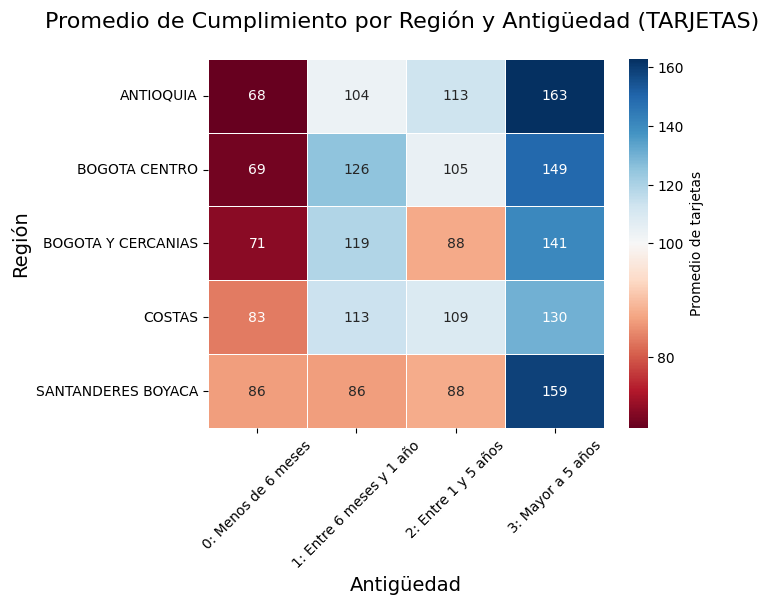

In [40]:
#### HEATMAP POR REGIÓN

# Crear el heatmap
data_region = df_activos.groupby(['region', 'antiguedad_cod'])[['cum tarjetas']].mean().reset_index()
data_pivot = data_region.pivot(index='region', columns='antiguedad_cod', values='cum tarjetas')
data_pivot.fillna(0, inplace=True)

vmin = data_pivot.min().min()
vmax = data_pivot.max().max()
if vmin < 100 < vmax:
    vcenter = 100
else:
    vcenter = (vmin + vmax) / 2

divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Configurar el colormap con punto de divergencia en 100
ax = sns.heatmap(data_pivot, annot=True, fmt='.0f', cmap='RdBu', 
                 linewidths=0.5, cbar_kws={'label': 'Promedio de tarjetas'},
                 norm=divnorm)

plt.title("Promedio de Cumplimiento por Región y Antigüedad (TARJETAS) \n", fontsize=16)
ax.set_xlabel("Antigüedad", fontsize=14)
ax.set_ylabel("Región", fontsize=14)
plt.xticks(rotation=45)
plt.show()

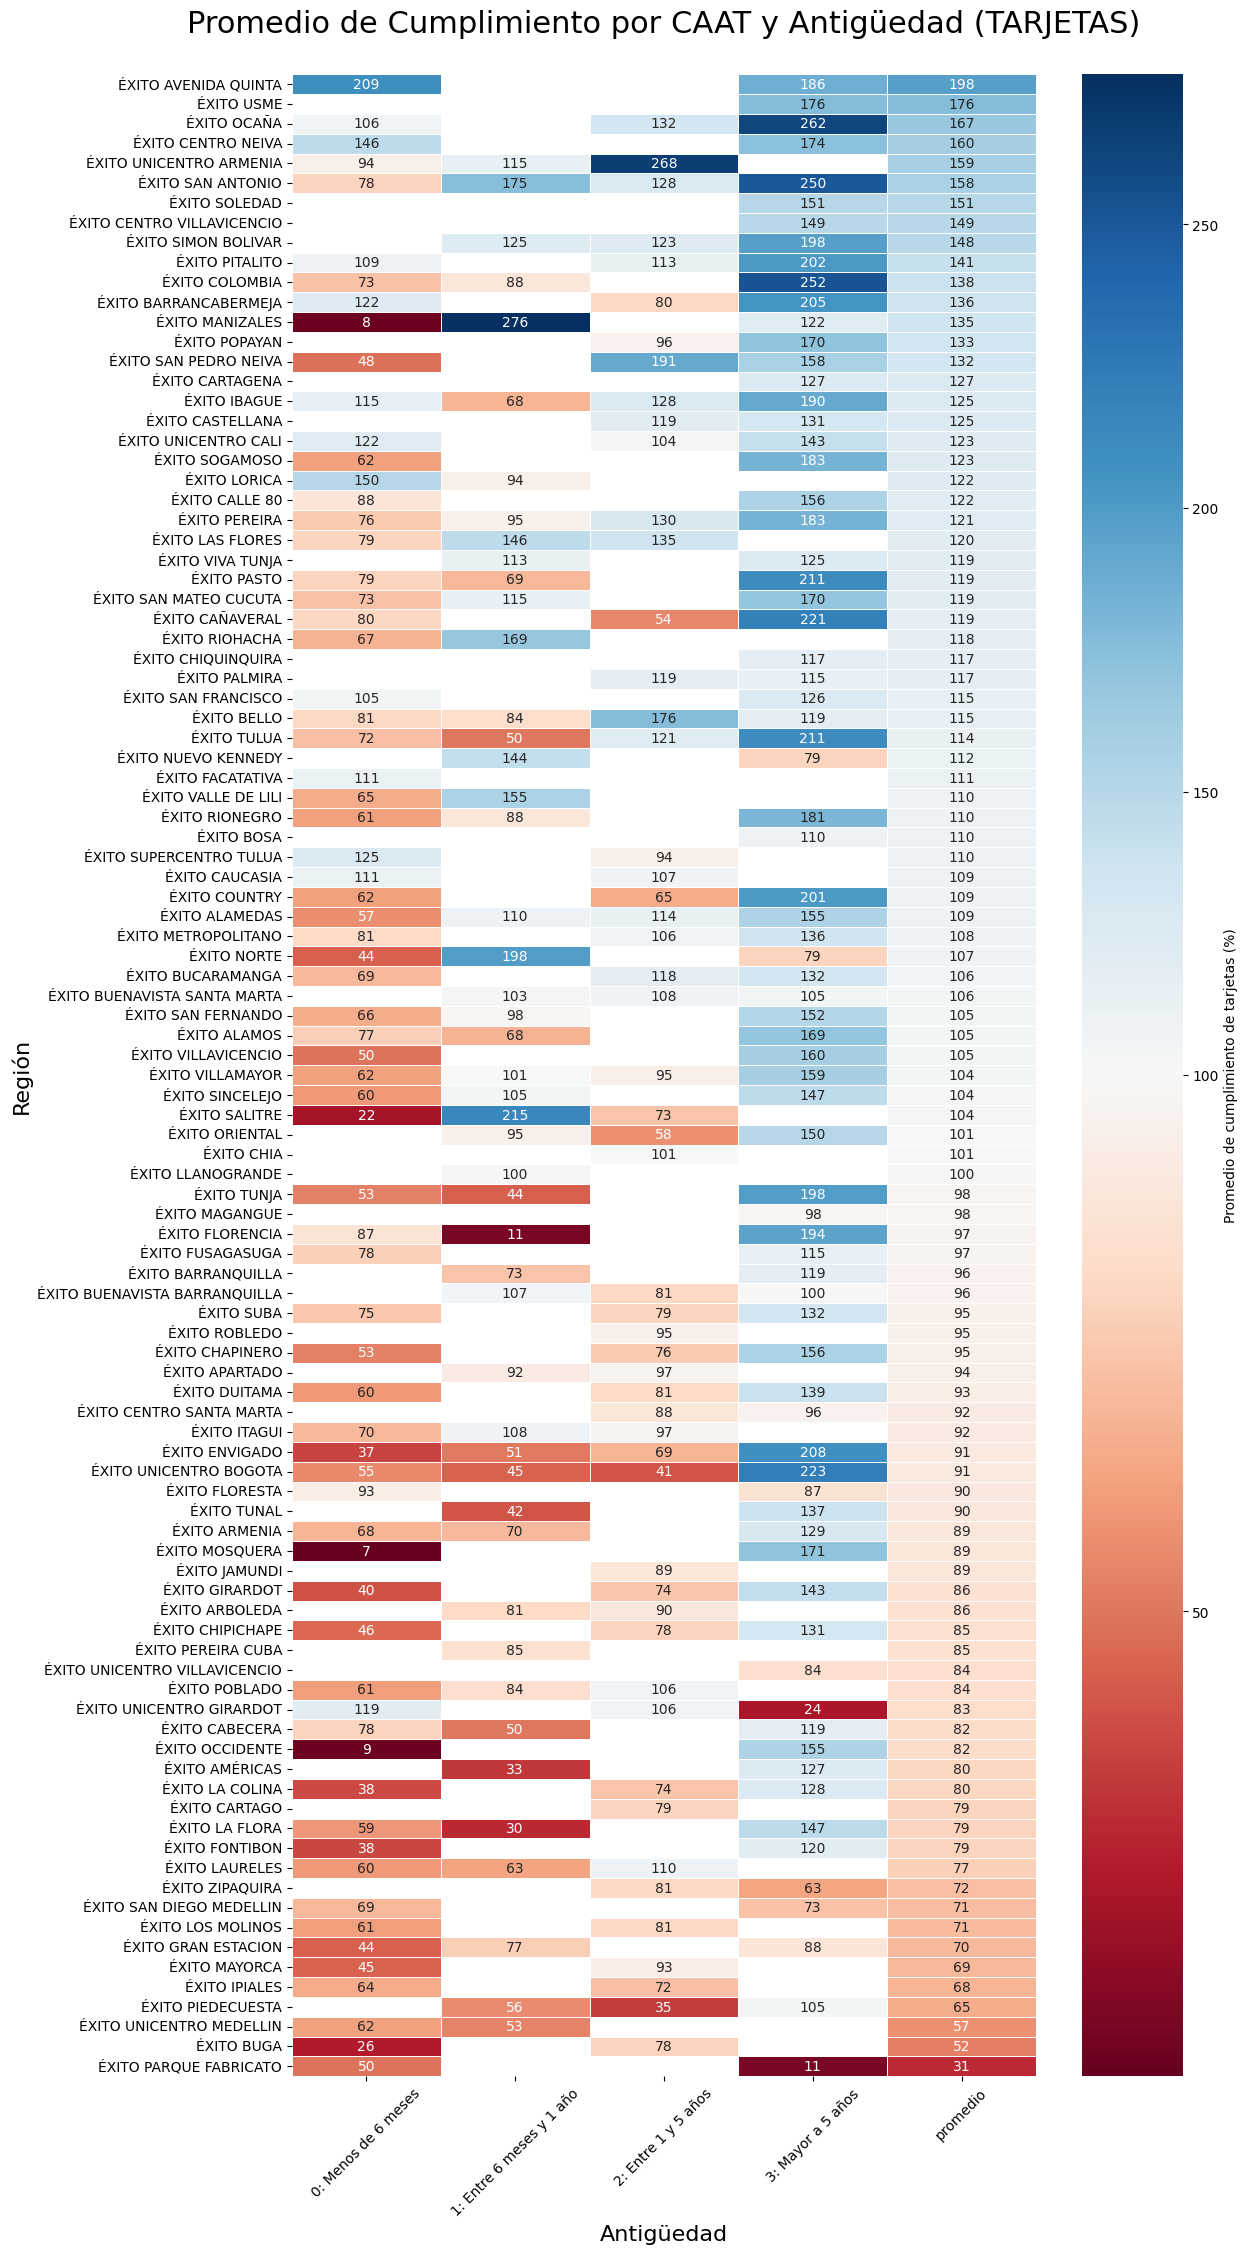

In [41]:
#### HEATMAP POR CATT

# Crear el heatmap
data_catt = df_activos.groupby(['catt', 'antiguedad_cod'])[['cum tarjetas']].mean().reset_index()
data_pivot = data_catt.pivot(index='catt', columns='antiguedad_cod', values='cum tarjetas')

# Calcular promedio y ordenar
data_pivot['promedio'] = data_pivot.mean(axis=1)
data_pivot = data_pivot.sort_values(by='promedio', ascending=False)

vmin = data_pivot.min().min()
vmax = data_pivot.max().max()
if vmin < 100 < vmax:
    vcenter = 100
else:
    vcenter = (vmin + vmax) / 2

divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Configurar el heatmap con punto de divergencia en 100
plt.figure(figsize=(12, 26))
ax = sns.heatmap(
    data_pivot, 
    annot=True, 
    fmt='.0f', 
    cmap='RdBu', 
    linewidths=0.5, 
    cbar_kws={'label': 'Promedio de cumplimiento de tarjetas (%)'},
    norm=divnorm
)

plt.title("Promedio de Cumplimiento por CAAT y Antigüedad (TARJETAS)\n", fontsize=22)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
ax.set_xlabel("Antigüedad", fontsize=16)
ax.set_ylabel("Región", fontsize=16)
plt.show()

### CRÉDITOS

In [42]:
# Gráfica 1: Distribución de Cumplimiento de Créditos por Región (Box Plot)

fig1 = px.box(df_activos, x='region', y='cum creditos', color='region',
              title='Distribución de Cumplimiento de Créditos por Región') 

fig1.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Créditos')
fig1.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig1.update_layout(legend=dict(title='Región'))
fig1.update_layout(template='plotly_white')
fig1.update_layout(width=1200, height=600)
fig1.show()

# Gráfica 2: Distribución de Cumplimiento de Créditos por Región y Antiguedad (Box Plot)

fig2 = px.box(df_activos, x='region', y='cum creditos', color='antiguedad_cod',
              title='Distribución de Cumplimiento de Créditos por Región',
                   category_orders={'antiguedad_cod': sorted(df_activos['antiguedad_cod'].unique())}) 

fig2.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Créditos')
fig2.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig2.update_layout(legend=dict(title='Antigüedad'))
fig2.update_layout(template='plotly_white')
fig2.update_layout(width=1200, height=600)
fig2.show()

# Gráfica3: Relación entre Créditos Vendidos y Cumplimiento (Scatter Plot)

fig3 = px.scatter(df_activos, x='Creditos', y='cum creditos', color='antiguedad_cod',
                   title='Relación entre Créditos Vendidos y Cumplimiento',
                   category_orders={'antiguedad_cod': sorted(df_activos['antiguedad_cod'].unique())}) 

fig3.update_layout(xaxis_title='Créditos Vendidos', yaxis_title='Cumplimiento de Créditos')
fig3.update_layout(legend=dict(title='Antigüedad'))
fig3.update_layout(template='plotly_white')
fig3.update_layout(width=1200, height=600)
fig3.show()

### HEATMAPS (CREDITOS)

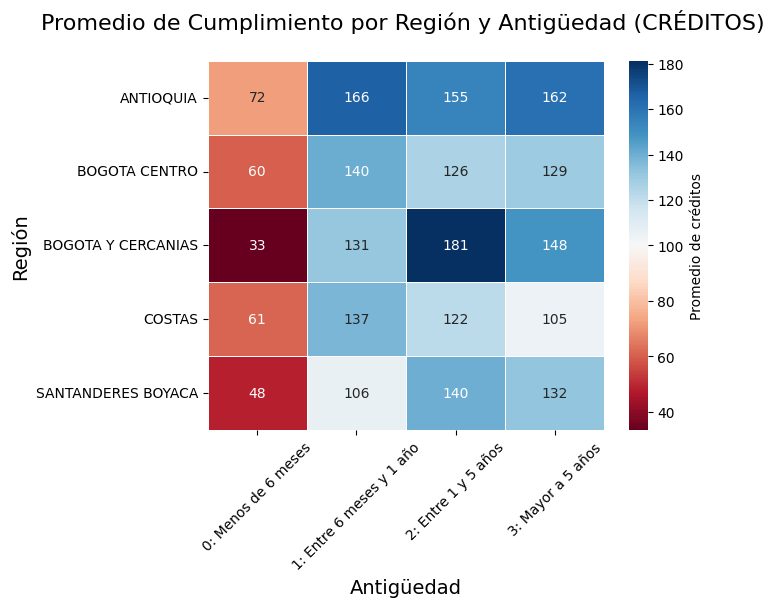

In [43]:
#### HEATMAP POR REGIÓN

# Crear el heatmap
data_region = df_activos.groupby(['region', 'antiguedad_cod'])[['cum creditos']].mean().reset_index()
data_pivot = data_region.pivot(index='region', columns='antiguedad_cod', values='cum creditos')
data_pivot.fillna(0, inplace=True)

vmin = data_pivot.min().min()
vmax = data_pivot.max().max()
if vmin < 100 < vmax:
    vcenter = 100
else:
    vcenter = (vmin + vmax) / 2

divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Configurar el colormap con punto de divergencia en 100
ax = sns.heatmap(data_pivot, annot=True, fmt='.0f', cmap='RdBu', 
                 linewidths=0.5, cbar_kws={'label': 'Promedio de créditos'},
                 norm=divnorm)

plt.title("Promedio de Cumplimiento por Región y Antigüedad (CRÉDITOS) \n", fontsize=16)
ax.set_xlabel("Antigüedad", fontsize=14)
ax.set_ylabel("Región", fontsize=14)
plt.xticks(rotation=45)
plt.show()

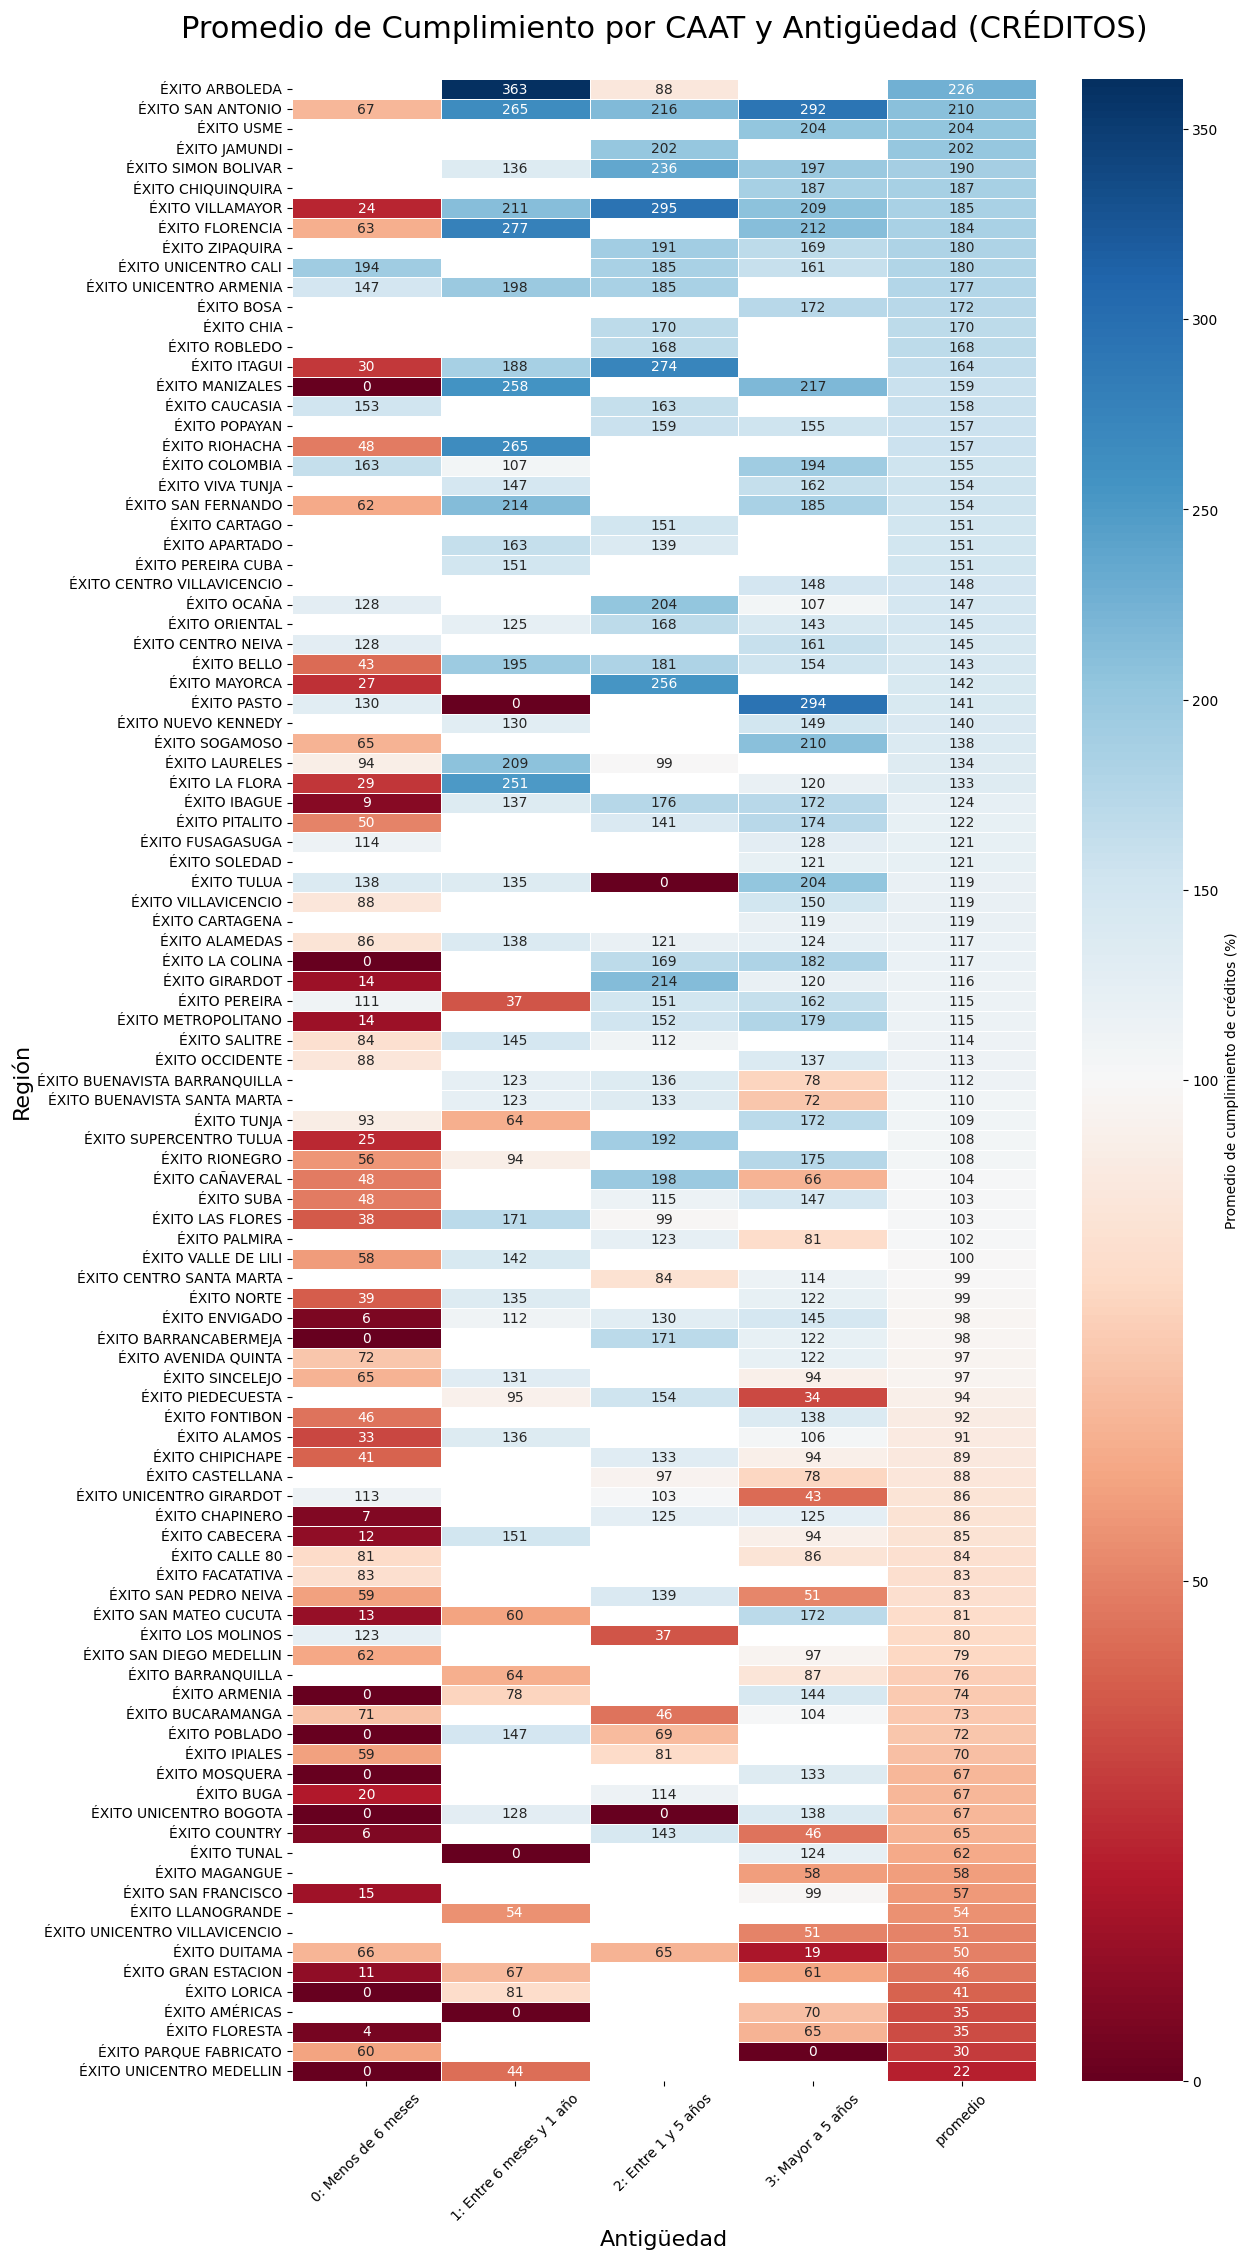

In [44]:
#### HEATMAP POR CATT

# Crear el heatmap
data_catt = df_activos.groupby(['catt', 'antiguedad_cod'])[['cum creditos']].mean().reset_index()
data_pivot = data_catt.pivot(index='catt', columns='antiguedad_cod', values='cum creditos')

# Calcular promedio y ordenar
data_pivot['promedio'] = data_pivot.mean(axis=1)
data_pivot = data_pivot.sort_values(by='promedio', ascending=False)

vmin = data_pivot.min().min()
vmax = data_pivot.max().max()
if vmin < 100 < vmax:
    vcenter = 100
else:
    vcenter = (vmin + vmax) / 2

divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Configurar el heatmap con punto de divergencia en 100
plt.figure(figsize=(12, 26))
ax = sns.heatmap(
    data_pivot, 
    annot=True, 
    fmt='.0f', 
    cmap='RdBu', 
    linewidths=0.5, 
    cbar_kws={'label': 'Promedio de cumplimiento de créditos (%)'},
    norm=divnorm
)

plt.title("Promedio de Cumplimiento por CAAT y Antigüedad (CRÉDITOS)\n", fontsize=22)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
ax.set_xlabel("Antigüedad", fontsize=16)
ax.set_ylabel("Región", fontsize=16)
plt.show()

### SEGUROS

In [45]:
# Gráfica 1: Distribución de Cumplimiento de Seguros por Región (Box Plot)

fig1 = px.box(df_activos, x='region', y='cum seguros', color='region',
              title='Distribución de Cumplimiento de Seguros por Región') 

fig1.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Seguros')
fig1.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig1.update_layout(legend=dict(title='Región'))
fig1.update_layout(template='plotly_white')
fig1.update_layout(width=1200, height=600)
fig1.show()

# Gráfica 2: Distribución de Cumplimiento de Seguros por Región y Antiguedad (Box Plot)

fig2 = px.box(df_activos, x='region', y='cum seguros', color='antiguedad_cod',
              title='Distribución de Cumplimiento de Seguros por Región',
                   category_orders={'antiguedad_cod': sorted(df_activos['antiguedad_cod'].unique())}) 

fig2.update_layout(xaxis_title='Región', yaxis_title='Cumplimiento de Seguros')
fig2.update_layout(xaxis={'categoryorder':'category ascending', 'tickangle': 45})
fig2.update_layout(legend=dict(title='Antigüedad'))
fig2.update_layout(template='plotly_white')
fig2.update_layout(width=1200, height=600)
fig2.show()

# Gráfica3: Relación entre Seguros Vendidos y Cumplimiento (Scatter Plot)

fig3 = px.scatter(df_activos, x='Seguros', y='cum seguros', color='antiguedad_cod',
                   title='Relación entre Seguros Vendidos y Cumplimiento',
                   category_orders={'antiguedad_cod': sorted(df_activos['antiguedad_cod'].unique())}) 

fig3.update_layout(xaxis_title='Seguros Vendidos', yaxis_title='Cumplimiento de Seguros')
fig3.update_layout(legend=dict(title='Antigüedad'))
fig3.update_layout(template='plotly_white')
fig3.update_layout(width=1200, height=600)
fig3.show()

### HEATMAP (SEGUROS)

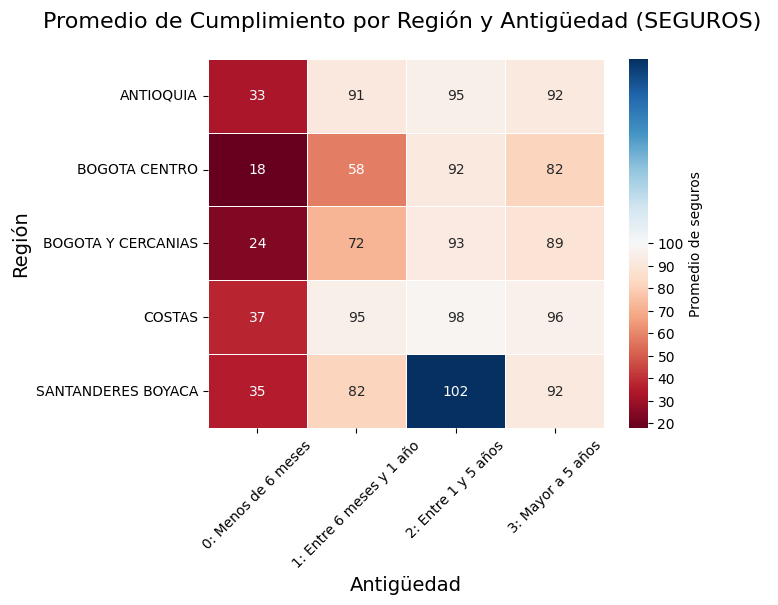

In [46]:
#### HEATMAP POR REGIÓN

# Crear el heatmap
data_region = df_activos.groupby(['region', 'antiguedad_cod'])[['cum seguros']].mean().reset_index()
data_pivot = data_region.pivot(index='region', columns='antiguedad_cod', values='cum seguros')
data_pivot.fillna(0, inplace=True)

vmin = data_pivot.min().min()
vmax = data_pivot.max().max()
if vmin < 100 < vmax:
    vcenter = 100
else:
    vcenter = (vmin + vmax) / 2

divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Configurar el colormap con punto de divergencia en 100
ax = sns.heatmap(data_pivot, annot=True, fmt='.0f', cmap='RdBu', 
                 linewidths=0.5, cbar_kws={'label': 'Promedio de seguros'},
                 norm=divnorm)

plt.title("Promedio de Cumplimiento por Región y Antigüedad (SEGUROS) \n", fontsize=16)
ax.set_xlabel("Antigüedad", fontsize=14)
ax.set_ylabel("Región", fontsize=14)
plt.xticks(rotation=45)
plt.show()

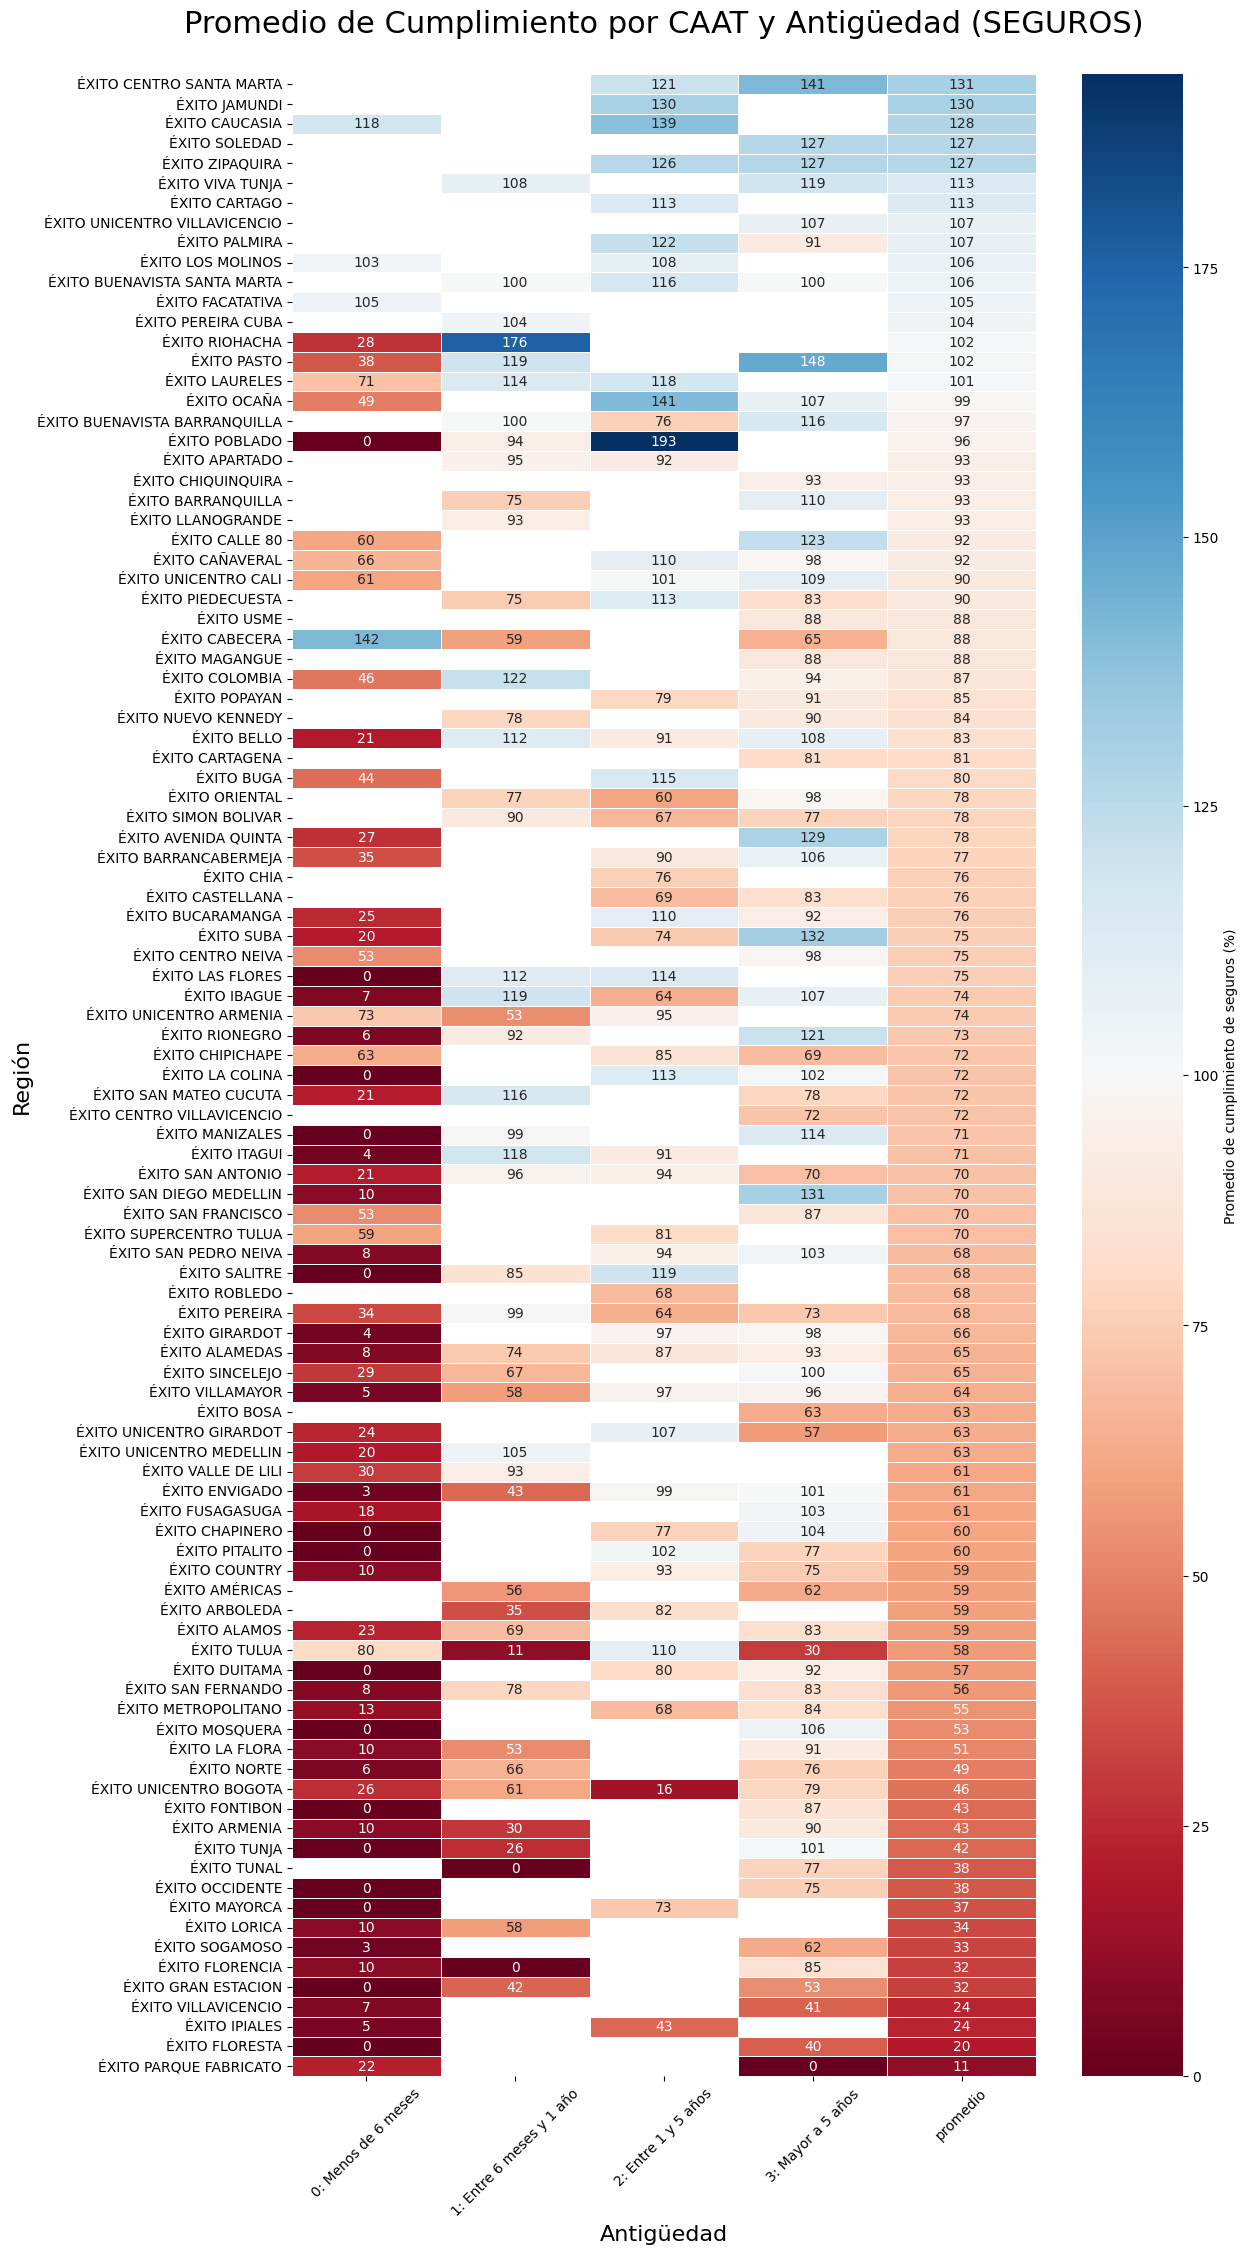

In [47]:
#### HEATMAP POR CATT

# Crear el heatmap
data_catt = df_activos.groupby(['catt', 'antiguedad_cod'])[['cum seguros']].mean().reset_index()
data_pivot = data_catt.pivot(index='catt', columns='antiguedad_cod', values='cum seguros')

# Calcular promedio y ordenar
data_pivot['promedio'] = data_pivot.mean(axis=1)
data_pivot = data_pivot.sort_values(by='promedio', ascending=False)

vmin = data_pivot.min().min()
vmax = data_pivot.max().max()
if vmin < 100 < vmax:
    vcenter = 100
else:
    vcenter = (vmin + vmax) / 2

divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Configurar el heatmap con punto de divergencia en 100
plt.figure(figsize=(12, 26))
ax = sns.heatmap(
    data_pivot, 
    annot=True, 
    fmt='.0f', 
    cmap='RdBu', 
    linewidths=0.5, 
    cbar_kws={'label': 'Promedio de cumplimiento de seguros (%)'},
    norm=divnorm
)

plt.title("Promedio de Cumplimiento por CAAT y Antigüedad (SEGUROS)\n", fontsize=22)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
ax.set_xlabel("Antigüedad", fontsize=16)
ax.set_ylabel("Región", fontsize=16)
plt.show()

In [48]:
# Export to CSV
df_activos.to_csv('df_activos.csv', index=True)

# Export to Excel
df_activos.to_excel('df_activos.xlsx', index=True)

print("Files have been saved successfully!")

Files have been saved successfully!
